## Instalando e Carregando os Pacotes

In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.0 MB/s eta 0:00:00


In [ ]:
# Imports
import os
import time
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
# Verifica o modelo da GPU
if torch.cuda.is_available():
    print('Número de GPUs:', torch.cuda.device_count())
    print('Modelo GPU:', torch.cuda.get_device_name(0))
    print('Total Memória [GB] da GPU:',torch.cuda.get_device_properties(0).total_memory / 1e9)

Número de GPUs: 1
Modelo GPU: NVIDIA A100-SXM4-40GB
Total Memória [GB] da GPU: 42.481811456


In [ ]:
# Reset da memória da GPU
from numba import cuda
device = cuda.get_current_device()
device.reset()

## Organizando as Imagens em Disco

In [ ]:
# Deleta as pastas (se existirem)
try:
    shutil.rmtree('EuroSAT_RGB')
    shutil.rmtree('__MACOSX')
    shutil.rmtree('imagens_treino')
    shutil.rmtree('imagens_teste')
except Exception as e:
    print(f"As pastas não existem ou já foram deletadas!")

As pastas não existem ou já foram deletadas!


In [ ]:
# Use apenas na primeira vez que executar o projeto
!unzip EuroSAT_RGB.zip

Streaming output truncated to the last 5000 lines.
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2494.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2494.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2480.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2480.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_292.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_292.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_1189.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_1189.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_1837.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_1837.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_2496.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._PermanentCrop_2496.jpg  
  inflating: EuroSAT_RGB/PermanentCrop/PermanentCrop_284.jpg  
  inflating: __MACOSX/EuroSAT_RGB/PermanentCrop/._Perm

In [ ]:
# Crie as pastas
os.mkdir('imagens_treino')
os.mkdir('imagens_teste')

In [ ]:
# Defina a fonte
imagens_fonte = 'EuroSAT_RGB'

In [ ]:
# Defina o destino
destino_treino = 'imagens_treino'
destino_teste = 'imagens_teste'

## Automatizando a Separação das Imagens

In [ ]:
# Variável de classe e dicionário
image_class = 0
class_dict = {}

In [ ]:
# Cria a variável para manipular as imagens
arquivos = os.listdir(imagens_fonte)
arquivos.sort()

In [ ]:
arquivos

['.DS_Store',
 'AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [ ]:
# Itera sobre todos os arquivos (ou diretórios) na lista 'arquivos'
for caminho_arquivo in arquivos:

    # Checa se o nome do arquivo (ou diretório) não começa com um ponto (isto é, não é um arquivo oculto)
    if caminho_arquivo[0] != '.':

        # Lista todas as imagens no diretório especificado
        images = os.listdir(imagens_fonte + '/' + caminho_arquivo)

        # Calcula o tamanho da amostra para o conjunto de treinamento (80% do total de imagens)
        sample_size = int(len(images) * 0.8)

        # Inicializa uma lista vazia para guardar os nomes das imagens de treinamento
        train = []

        # Define o destino final para as imagens de treinamento
        final_dest = destino_treino + '/' + str(image_class)

        # Cria um novo diretório para as imagens de treinamento
        os.mkdir(final_dest)

        # Seleciona uma amostra aleatória das imagens para o conjunto de treinamento e as copia para o destino final
        for file_name in random.sample(images, sample_size):

            # Copia a imagem para o diretório de destino
            shutil.copy2(os.path.join(imagens_fonte, caminho_arquivo, file_name), final_dest)

            # Adiciona o nome da imagem à lista de treinamento
            train.append(file_name)

        # Obtém a lista de imagens que não foram selecionadas para treinamento (ou seja, imagens de teste)
        test_images = list(set(images) - set(train))

        # Define o destino final para as imagens de teste
        final_dest = destino_teste + '/' + str(image_class)

        # Cria um novo diretório para as imagens de teste
        os.mkdir(final_dest)

        # Copia todas as imagens de teste para o diretório de destino
        for test_image in test_images:
            shutil.copy2(os.path.join(imagens_fonte, caminho_arquivo, test_image), final_dest)

        # Associa a classe da imagem ao seu respectivo caminho de arquivo no dicionário 'class_dict'
        class_dict[image_class] = caminho_arquivo

        # Incrementa o identificador da classe da imagem
        image_class += 1

## Pré-Processamento e Criação de Dataloaders

In [ ]:
# Transformações nos dados
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# Dataset de treino
dataset_treino = torchvision.datasets.ImageFolder(root = 'imagens_treino', transform = transform)

In [ ]:
# Dataloader de treino
dl_treino = torch.utils.data.DataLoader(dataset_treino, batch_size = 64, shuffle = True, num_workers = 2)

In [ ]:
# Dataset de teste
dataset_teste = torchvision.datasets.ImageFolder(root = 'imagens_teste', transform = transform)

In [ ]:
# Dataloader de teste
dl_teste = torch.utils.data.DataLoader(dataset_teste, batch_size = 1, shuffle = True, num_workers = 2)

## Visualizando as Imagens

In [ ]:
# Função para visualizar imagens
def imshow(img):

    # Carrega e normaliza a imagem
    img = img / 2 + 0.5

    # Converte a imagem em array numpy
    npimg = img.numpy()

    # Mostra a imagem
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# Obtém um lote de imagens
dataiter = iter(dl_treino)
images, labels = next(dataiter)

In [ ]:
mapeamento = {0:'AnnualCrop',
              1:'Forest',
              2:'HerbaceousVegetation',
              3:'Highway',
              4:'Industrial',
              5:'Pasture',
              6:'PermanentCrop',
              7:'Residential',
              8:'River',
              9:'SeaLake'}

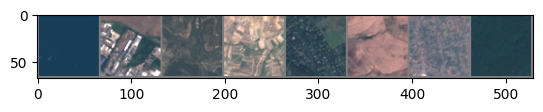

Labels: 9 4 2 6 7 2 7 1


In [ ]:
# Mostra a imagem
imshow(torchvision.utils.make_grid(images[:8]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(8)))

## Modelagem - Construção do Modelo de Deep Learning

In [ ]:
# Define uma nova classe de modelo chamada DSANet, que herda de nn.Module
class DSANet(nn.Module):

    # Método construtor da classe
    def __init__(self):

        # Chama o construtor da classe pai (nn.Module)
        super(DSANet, self).__init__()

        # Define a primeira camada de convolução com 3 canais de entrada, 64 de saída
        # e um kernel de tamanho 3x3
        self.conv1 = nn.Conv2d(3, 64, 3, 1)

        # Define a segunda camada de convolução com 64 canais de entrada, 128 de saída
        # e um kernel de tamanho 3x3
        self.conv2 = nn.Conv2d(64, 128, 3, 1)

        # Define a terceira camada de convolução com 128 canais de entrada, 256 de saída
        # e um kernel de tamanho 3x3
        self.conv3 = nn.Conv2d(128, 256, 3, 1)

        # Define a primeira camada de dropout com probabilidade de 0.25
        self.dropout1 = nn.Dropout(0.25)

        # Define a segunda camada de dropout com probabilidade de 0.5
        self.dropout2 = nn.Dropout(0.5)

        # Define a primeira camada totalmente conectada (Dense) que mapeia de 215296 para 2048 neurônios
        self.fc1 = nn.Linear(215296, 2048)

        # Define a segunda camada totalmente conectada que mapeia de 2048 para 512 neurônios
        self.fc2 = nn.Linear(2048, 512)

        # Define a terceira camada totalmente conectada que mapeia de 512 para 128 neurônios
        self.fc3 = nn.Linear(512, 128)

        # Define a quarta camada totalmente conectada que mapeia de 128 para 10 neurônios
        self.fc4 = nn.Linear(128, 10)

    # Define o método forward para a passagem para frente
    def forward(self, x):

        # Aplica a primeira camada de convolução
        x = self.conv1(x)

        # Aplica a função de ativação ReLU
        x = F.relu(x)

        # Aplica a segunda camada de convolução
        x = self.conv2(x)

        # Aplica a função de ativação ReLU
        x = F.relu(x)

        # Aplica a terceira camada de convolução
        x = self.conv3(x)

        # Aplica a função de ativação ReLU
        x = F.relu(x)

        # Aplica max pooling com um kernel de tamanho 2x2
        x = F.max_pool2d(x, 2)

        # Aplica a primeira camada de dropout
        x = self.dropout1(x)

        # "Achata" o tensor para preparar para a camada totalmente conectada
        x = torch.flatten(x, 1)

        # Aplica a primeira camada totalmente conectada
        x = self.fc1(x)

        # Aplica a função de ativação ReLU
        x = F.relu(x)

        # Aplica a segunda camada de dropout
        x = self.dropout2(x)

        # Aplica a segunda camada totalmente conectada
        x = self.fc2(x)

        # Aplica a função de ativação ReLU
        x = F.relu(x)

        # Aplica a terceira camada totalmente conectada
        x = self.fc3(x)

        # Aplica a função de ativação ReLU
        x = F.relu(x)

        # Aplica a quarta camada totalmente conectada
        x = self.fc4(x)

        # Retorna a softmax do tensor resultante ao longo da dimensão 1 (geralmente usada para classificação)
        return F.log_softmax(x, dim = 1)

In [ ]:
# Cria o modelo
modelo = DSANet()

In [ ]:
print(modelo)

DSANet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Define o device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Manda o modelo para o device
modelo.to(device)

DSANet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

## Selecionando a Função de Erro

In [ ]:
# Função de erro
criterion = nn.CrossEntropyLoss()

## Selecionando o Otimizador

In [ ]:
# Otimizador
optimizer = optim.Adam(modelo.parameters())

## Treinamento do Modelo

In [ ]:
# Número de épocas
num_epochs = 30

In [ ]:
# Iteração de teste
testiter = iter(dl_teste)

In [ ]:
%%time
print('Treinamento Iniciado!')

# Itera sobre o número de épocas
for epoch in range(num_epochs):

    # Inicializa a variável que acumula a perda ao longo da época
    running_loss = 0.0

    # Inicializa um contador para os batches
    i = 0

    # Itera sobre os dados de treinamento com uma barra de progresso (tqdm)
    for data in (pbar := tqdm(dl_treino)):

        # Atualiza a descrição da barra de progresso para mostrar a época atual
        pbar.set_description(f"\nEpoch {epoch}")

        # Descompacta o batch de dados em entradas e rótulos
        inputs, labels = data

        # Move as entradas e rótulos para o dispositivo correto (CPU ou GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zera os gradientes do otimizador
        optimizer.zero_grad()

        # Realiza a passagem para frente através da rede neural
        outputs = modelo(inputs)

        # Calcula a perda usando o critério definido
        loss = criterion(outputs, labels)

        # Realiza a passagem para trás para calcular os gradientes
        loss.backward()

        # Atualiza os pesos da rede neural usando o otimizador
        optimizer.step()

        # Atualiza o valor acumulado da perda
        running_loss += loss.item()

        # Inicializa contadores para o número correto de previsões e o número total de amostras
        total_correct = 0
        total_samples = 0

        # Se estamos em um batch múltiplo de 100
        if i % 100 == 0:

            # Desativa o cálculo dos gradientes para economizar memória e tempo de processamento
            with torch.no_grad():

                # Obtém um batch de imagens e rótulos de teste
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                # Realiza uma passagem para frente na rede neural com as 8 imagens de teste
                test_outputs = modelo(test_images[:8])

                # Obtem as previsões para as 8 imagens
                _, predicted = torch.max(test_outputs, 1)

        # Incrementa o contador de batches
        i += 1

    # Exibe a perda média para a época
    print(f"Epoch {epoch}, Loss: {running_loss / (i)}")

print('Treinamento Concluído!')

Treinamento Iniciado!


Epoch 0: 100%|██████████| 338/338 [00:19<00:00, 17.54it/s]


Epoch 0, Loss: 1.1332014197781242


Epoch 1: 100%|██████████| 338/338 [00:17<00:00, 19.08it/s]


Epoch 1, Loss: 0.6738050126817805


Epoch 2: 100%|██████████| 338/338 [00:17<00:00, 19.08it/s]


Epoch 2, Loss: 0.47919619189211604


Epoch 3: 100%|██████████| 338/338 [00:17<00:00, 19.06it/s]


Epoch 3, Loss: 0.32762323249373915


Epoch 4: 100%|██████████| 338/338 [00:17<00:00, 19.05it/s]


Epoch 4, Loss: 0.23342741532085914


Epoch 5: 100%|██████████| 338/338 [00:17<00:00, 19.09it/s]


Epoch 5, Loss: 0.1612596338526649


Epoch 6: 100%|██████████| 338/338 [00:17<00:00, 19.05it/s]


Epoch 6, Loss: 0.12047771588739382


Epoch 7: 100%|██████████| 338/338 [00:17<00:00, 19.07it/s]


Epoch 7, Loss: 0.10390777495337


Epoch 8: 100%|██████████| 338/338 [00:17<00:00, 19.06it/s]


Epoch 8, Loss: 0.08355119327198957


Epoch 9: 100%|██████████| 338/338 [00:17<00:00, 19.09it/s]


Epoch 9, Loss: 0.07019725498228786


Epoch 10: 100%|██████████| 338/338 [00:17<00:00, 19.03it/s]


Epoch 10, Loss: 0.08068184949321254


Epoch 11: 100%|██████████| 338/338 [00:17<00:00, 19.05it/s]


Epoch 11, Loss: 0.061544834687815395


Epoch 12: 100%|██████████| 338/338 [00:17<00:00, 19.05it/s]


Epoch 12, Loss: 0.053832378358643546


Epoch 13: 100%|██████████| 338/338 [00:17<00:00, 19.03it/s]


Epoch 13, Loss: 0.05104167719921662


Epoch 14: 100%|██████████| 338/338 [00:17<00:00, 19.04it/s]


Epoch 14, Loss: 0.05005735662649041


Epoch 15: 100%|██████████| 338/338 [00:17<00:00, 19.02it/s]


Epoch 15, Loss: 0.04784694120066431


Epoch 16: 100%|██████████| 338/338 [00:17<00:00, 19.09it/s]


Epoch 16, Loss: 0.044368751236935386


Epoch 17: 100%|██████████| 338/338 [00:17<00:00, 19.03it/s]


Epoch 17, Loss: 0.030310854675551703


Epoch 18: 100%|██████████| 338/338 [00:17<00:00, 19.08it/s]


Epoch 18, Loss: 0.04482362238436051


Epoch 19: 100%|██████████| 338/338 [00:17<00:00, 19.03it/s]


Epoch 19, Loss: 0.04629164218522688


Epoch 20: 100%|██████████| 338/338 [00:17<00:00, 19.06it/s]


Epoch 20, Loss: 0.03958429439455207


Epoch 21: 100%|██████████| 338/338 [00:17<00:00, 19.04it/s]


Epoch 21, Loss: 0.051266876182545766


Epoch 22: 100%|██████████| 338/338 [00:17<00:00, 19.09it/s]


Epoch 22, Loss: 0.026884275759315773


Epoch 23: 100%|██████████| 338/338 [00:17<00:00, 19.04it/s]


Epoch 23, Loss: 0.05054040219363624


Epoch 24: 100%|██████████| 338/338 [00:17<00:00, 19.08it/s]


Epoch 24, Loss: 0.04366274011486173


Epoch 25: 100%|██████████| 338/338 [00:17<00:00, 19.06it/s]


Epoch 25, Loss: 0.02642682697465533


Epoch 26: 100%|██████████| 338/338 [00:17<00:00, 19.06it/s]


Epoch 26, Loss: 0.026903874230299944


Epoch 27: 100%|██████████| 338/338 [00:17<00:00, 19.02it/s]


Epoch 27, Loss: 0.022344429344229866


Epoch 28: 100%|██████████| 338/338 [00:17<00:00, 19.01it/s]


Epoch 28, Loss: 0.029698999496419874


Epoch 29: 100%|██████████| 338/338 [00:17<00:00, 19.08it/s]

Epoch 29, Loss: 0.04709095425454582
Treinamento Concluído!
CPU times: user 8min 40s, sys: 17.3 s, total: 8min 58s
Wall time: 8min 53s


## Avaliação do Modelo

In [ ]:
# Inicializa os contadores
total_correct = 0
total_samples = 0

In [ ]:
# Coloca o modelo em modo de avaliação (isso desativa camadas como dropout e batch normalization)
modelo.eval()

# Desativa o cálculo dos gradientes para economizar memória e tempo de processamento
with torch.no_grad():

    # Itera sobre os dados de teste com uma barra de progresso (tqdm)
    for data in (pbar := tqdm(dl_teste)):

        # Atualiza a descrição da barra de progresso para mostrar "Avaliando o Modelo"
        pbar.set_description(f"Avaliando o Modelo.")

        # Descompacta o batch de dados em entradas e rótulos
        inputs, labels = data

        # Move as entradas e rótulos para o dispositivo correto (CPU ou GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Realiza a passagem para frente através do modelo
        outputs = modelo(inputs)

        # Obtem a classe prevista (índice do valor máximo) para cada entrada no batch
        _, predicted = torch.max(outputs.data, 1)

        # Incrementa o total de amostras pelo número de rótulos no batch atual
        total_samples += labels.size(0)

        # Incrementa o total de previsões corretas pelo número de previsões corretas no batch atual
        total_correct +=  (predicted == labels).sum().item()

Avaliando o Modelo.: 100%|██████████| 5400/5400 [00:23<00:00, 225.84it/s]


In [ ]:
# Calcula a acurácia
accuracy = total_correct/total_samples
print(accuracy)

0.825925925925926


## Deploy e Uso do Modelo

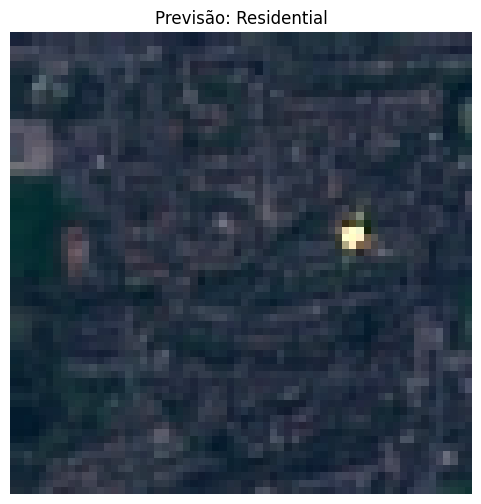

In [ ]:
# Coloca o modelo em modo de avaliação
with torch.no_grad():

    # Obtém o primeiro lote de dados
    data_iter = iter(dl_teste)
    data = next(data_iter)

    # Obtém os inputs (imagens)
    inputs, _ = data

    # Seleciona a primeira imagem do lote
    imagem = inputs[0].unsqueeze(0)

    # Move a imagem para o mesmo dispositivo que o modelo
    imagem = imagem.to(device)

    # Obtém a previsão do modelo para essa imagem
    outputs = modelo(imagem)

    # Obtém o índice da classe prevista
    _, predicted = torch.max(outputs, 1)

    # Converte a imagem para formato numpy para visualização
    # Move a imagem de volta para CPU e converte para numpy
    imagem_numpy = imagem.cpu().numpy()[0]

    # As imagens normalmente estão no formato [C, H, W], então você precisa reordenar para [H, W, C] para a visualização
    # Isso também depende do tipo de dados da imagem, pode ser necessário normalizar ou ajustar o range para visualização correta
    imagem_numpy = np.transpose(imagem_numpy, (1, 2, 0))

    # Ajusta os canais de imagem se necessário (por exemplo, se estiver em escala de cinza ou se a normalização foi aplicada)
    if imagem_numpy.shape[2] == 1:  # Imagens em escala de cinza
        imagem_numpy = np.squeeze(imagem_numpy, axis=2)
    elif imagem_numpy.shape[2] == 3:  # Imagens RGB
        imagem_numpy = (imagem_numpy - imagem_numpy.min()) / (imagem_numpy.max() - imagem_numpy.min())  # Normaliza para 0-1 se necessário

    plt.figure(figsize=(6, 6))
    plt.imshow(imagem_numpy)
    plt.title(f'Previsão: {mapeamento[predicted.item()]}')
    plt.axis('off')
    plt.show()